In [1]:
import pandas as pd

courses = pd.read_csv("courses-cleaned.csv")

In [2]:
courses.sample(7)

,Unnamed: 0,course_name,category,skills,certificate,teacher,course_level,course_rating,course_link,price,hpw
56,56,Тестирование REST API в Postman - легкий старт...,Веб-разработка,"['JavaScript', 'Postman']",Сертификат Stepik,['Давид Согоян'],Начальный уровень,5.0,https://stepik.org/course/131052?search=713955...,890.0,8.0
265,265,"Создание Cinematic на Unreal Engine 4.х, 5.0 (...",Анимация и моушн-дизайн,[],No,['Maxim Danilchenko'],Начальный уровень,4.5,https://stepik.org/course/109673?search=713982...,0.0,4.5
174,174,Квантовые вычисления и квантовая криптография,Информационная безопасность,[],Сертификат Stepik,['No instructor found'],Начальный уровень,5.0,https://stepik.org/course/187647?search=713971...,690.0,4.5
493,493,Как написать текст песни. Работающая технология.,Музыка и танец,[],Сертификат Stepik,['Серафим Текстура'],Начальный уровень,4.5,https://stepik.org/course/119807?search=714151...,2000.0,2.0
271,271,Шоу дронов: от разработки анимации до запуска роя,Анимация и моушн-дизайн,[],No,['Лев Синюков'],Начальный уровень,5.0,https://stepik.org/course/123912?search=713982...,4990.0,3.0
443,443,Basic Life Support and Automated External Defi...,Первая помощь,['Go'],Сертификат Stepik,"['Alexei Birkun', 'Visith Risira Dantanarayana']",Средний уровень,4.7,https://stepik.org/course/48612?search=7141504192,0.0,4.5
158,158,Agile: создание вашей Agile-команды,Менеджмент в ИТ,['Agile'],Сертификат Stepik,"['Agile Uni', 'Aleksandr Filippov']",Начальный уровень,4.5,https://stepik.org/course/212056?search=713970...,1690.0,4.5


In [3]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
import ast

def parse_skills(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

courses['skills'] = courses['skills'].apply(parse_skills)
courses['teacher'] = courses['teacher'].apply(parse_skills)

In [6]:
import joblib

categorical_cols = ['category', 'course_level']
numerical_cols = ['course_rating', 'price', 'hpw', 'certificate_binary']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

mlb_skills = MultiLabelBinarizer()
mlb_teacher = MultiLabelBinarizer()
    
skills_encoded = mlb_skills.fit_transform(courses['skills'])
teacher_encoded = mlb_teacher.fit_transform(courses['teacher'])

preprocessor.fit(courses)
joblib.dump(preprocessor, "pkl/preprocessor.pkl")

def preprocess_courses_with_feature_ranges(courses):
    X_partial = preprocessor.transform(courses)
    if hasattr(X_partial, 'toarray'):
        X_partial = X_partial.toarray()
    
    X_final = np.hstack([X_partial, skills_encoded, teacher_encoded])

    cat_feature_count = preprocessor.named_transformers_['cat'].categories_[0].shape[0] + \
                        preprocessor.named_transformers_['cat'].categories_[1].shape[0]

    skills_feature_start = X_partial.shape[1]
    skills_feature_end = skills_feature_start + skills_encoded.shape[1]

    return preprocessor, mlb_skills, mlb_teacher, X_final, cat_feature_count, skills_feature_start, skills_feature_end

In [7]:
def recommend_courses_cosine_weighted_filtered(
    user_input, preprocessor, mlb_skills, mlb_teacher, courses,
    X_final, cat_feature_count, skills_start, skills_end,
    weight_category=5, weight_skills=4, top_n=5
):
    user_df = pd.DataFrame([{
        'category': user_input.get('category', ''),
        'course_level': user_input.get('course_level', ''),
        'course_rating': user_input.get('course_rating', 0),
        'price': user_input.get('price', 0),
        'hpw': user_input.get('hpw', 0),
        'certificate_binary': 1 if user_input.get('certificate', False) else 0,
        'skills': user_input.get('skills', []),
        'teacher': user_input.get('teacher', [])
    }])

    X_partial = preprocessor.transform(user_df)
    if hasattr(X_partial, 'toarray'):
        X_partial = X_partial.toarray()

    skills_encoded = mlb_skills.transform(user_df['skills'])
    teacher_encoded = mlb_teacher.transform(user_df['teacher'])

    user_vec = np.hstack([X_partial, skills_encoded, teacher_encoded])

    user_vec_weighted = user_vec.copy()
    X_final_weighted = X_final.copy()

    user_vec_weighted[:, :cat_feature_count] *= weight_category
    X_final_weighted[:, :cat_feature_count] *= weight_category

    user_vec_weighted[:, skills_start:skills_end] *= weight_skills
    X_final_weighted[:, skills_start:skills_end] *= weight_skills

    similarities = cosine_similarity(user_vec_weighted, X_final_weighted)[0]

    sorted_indices = similarities.argsort()[::-1]

    user_skills_set = set(user_input.get('skills', []))

    filtered_indices = []
    for idx in sorted_indices:
        course_skills = set(courses.iloc[idx]['skills'])
        if user_skills_set.intersection(course_skills):
            filtered_indices.append(idx)
        if len(filtered_indices) == top_n:
            break

    if len(filtered_indices) < top_n:
        for idx in sorted_indices:
            if idx not in filtered_indices:
                filtered_indices.append(idx)
            if len(filtered_indices) == top_n:
                break

    recommendations = courses.iloc[filtered_indices].copy()
    recommendations['similarity'] = similarities[filtered_indices]

    return recommendations.reset_index(drop=True)

In [8]:
# preprocessor, mlb_skills, mlb_teacher, X_final, cat_feat_count, skills_start, skills_end = preprocess_courses_with_feature_ranges(courses)

# user_input = {
#     "category": "Музыка и танец",
#     "course_level": "",
#     "course_rating": 0,
#     "price": 0,
#     "hpw": 2,
#     "certificate": True,
#     "skills": [],
#     "teacher": []
# }

# recommendations = recommend_courses_cosine_weighted_filtered(
#     user_input, preprocessor, mlb_skills, mlb_teacher, courses, X_final,
#     cat_feat_count, skills_start, skills_end,
#     weight_category=10, weight_skills=2, top_n=5
# )
# print(recommendations[['course_name', 'category', 'skills', 'similarity', 'price']])

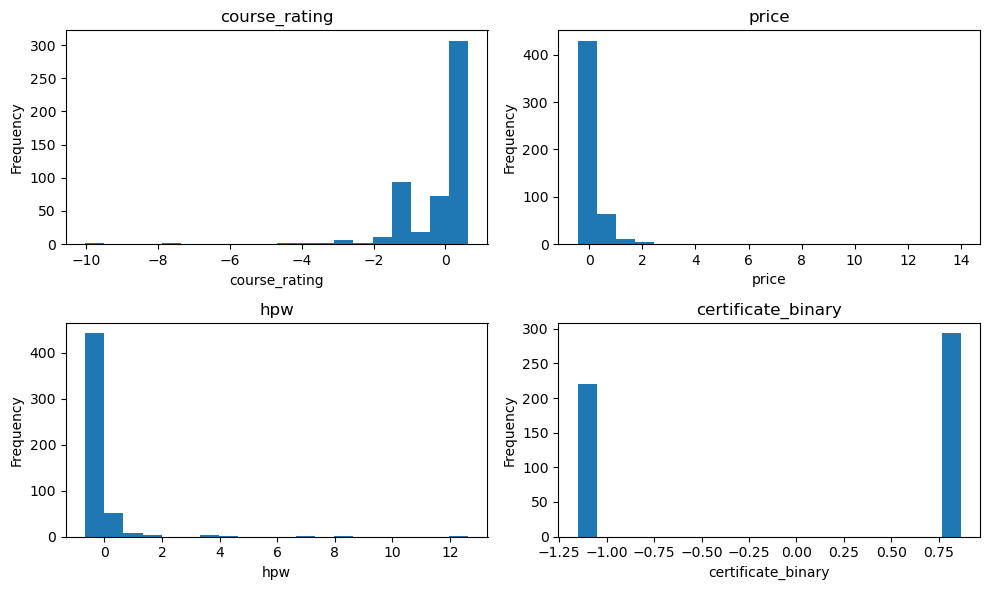

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Apply the transformation
X_preprocessed = preprocessor.fit_transform(courses)

# The transformed numerical columns are scaled and concatenated with categorical one-hot encoded columns.
# We need to locate where numerical columns are in X_preprocessed.

# OneHotEncoder expands categorical columns, so numerical columns are at the end (or depending on your ColumnTransformer order).

# Get number of categorical features after one-hot encoding
cat_ohe = preprocessor.named_transformers_['cat']
num_cat_features = cat_ohe.transform(courses[categorical_cols]).shape[1]

# Numerical columns start after categorical encoded features
num_start = num_cat_features
num_end = num_cat_features + len(numerical_cols)

# Extract only numerical features after scaling
X_num_scaled = X_preprocessed[:, num_start:num_end]

# Plot histograms for scaled numerical features
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2 rows, 2 columns, smaller size

for i, col in enumerate(numerical_cols):
    ax = axes[i // 2, i % 2]  # row and col index
    # Convert sparse to dense and flatten
    data = X_num_scaled[:, i].toarray().ravel()
    ax.hist(data, bins=20)
    ax.set_title(f'{col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [10]:
courses.certificate_binary.unique()

array([0, 1], dtype=int64)